In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import signal
from collections import OrderedDict
from pylab import rcParams
plt.style.use('ggplot')
defaults = OrderedDict((('width', 8), ('height', 4)))
rcParams['figure.figsize'] = defaults.values()
rcParams['legend.frameon'] = True
rcParams['legend.framealpha'] = 0.8
rcParams['figure.titlesize'] = 'large'
rcParams['font.size'] = 8
rcParams['legend.fontsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8

In this notebook we will apply the Fourier Transform to two common problems in
time series analysis: outlier detection and extrapolation.

## Outlier detection in periodical data

An outlier is an event or observation that deviates from what is considered the expected patter
of other observations in the dataset. In general, if we assume that a dataset of observation is generated by
some stochastic process, an outlier is a measurement so extreme that appears to have been generated
by a different mechanism.

In practice we, an anomalous observation will often indicate some kind of problem: a fraud in a set of credit cards transactions, malfunctioning of a measuring sensor, spikes in web traffic generated by a botnet.

### Dataset

In this lab we will analyize a dataset of the monthly numbers of [sunspots](https://en.wikipedia.org/wiki/Sunspot) recorded by the World Data Center. Sunspots are physical phenomena defined by wikipedia as follows:

> Sunspots are temporary phenomena on the photosphere of the Sun that appear as dark spots compared to surrounding regions. They are areas of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. [...] Due to its link to other kinds of solar activity, sunspot occurrence can be used to help predict space weather, the state of the ionosphere, and hence the conditions of short-wave radio propagation or satellite communications. Solar activity (and the solar cycle) have been implicated in global warming, originally the role of the Maunder Minimum of sunspot occurrence in the Little Ice Age in European winter climate. Sunspots themselves, in terms of the magnitude of their radiant-energy deficit, have a weak effect on terrestrial climate in a direct sense. On longer time scales, such as the solar cycle, other magnetic phenomena (faculae and the chromospheric network) correlate with sunspot occurrence.

We provide you a with a univariate timeserie reporting the number of months since January 1749, and the average number of daily sunspots recorded in that month. The data has been acquired from the [WDC-SILSO, Royal Observatory of Belgium, Brussels](http://www.sidc.be/silso/datafiles).

## Goal

In this exercise we will use Fourier analysis to identify abnormal numbers of sunspot observations.

This dataset if particularly interesting for us, because sunsposts phenomena show periodical patterns. FFT can help us identify this cycles, and reason about potential outliers.

**1. Load and visualize the dataset**

Load and plot the `data/sunspot.csv` dataset into a Pandas `DataFrame`. Label the  axes so that `x` reports  the
months since Jan 1749 and y the average number of sun spots that year. Make sure to create a `DatetimeIndex` with monthly dates ranging from 1749-01 onwards.

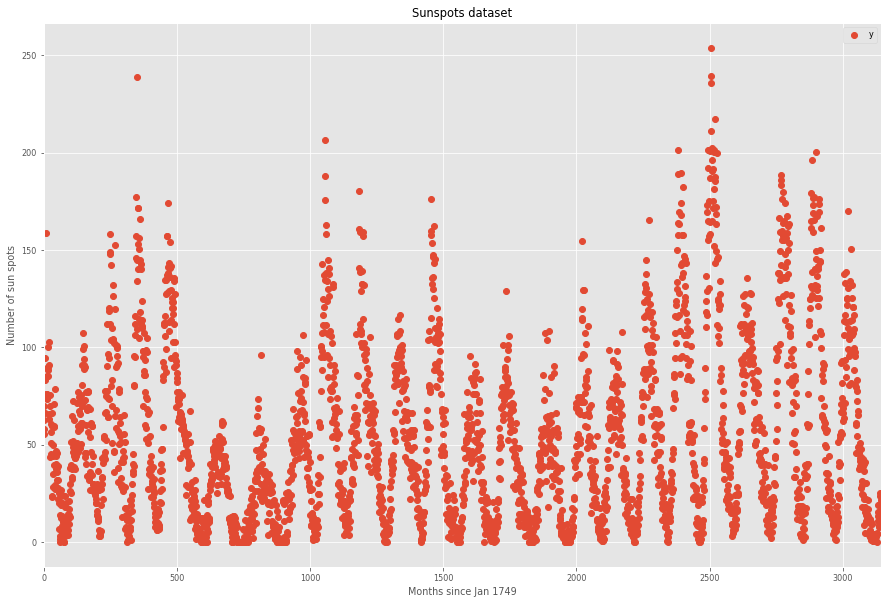

In [3]:
import pandas as pd
df = pd.read_csv('data/sunspots.csv', sep='\t', names=['x', 'y'])
index = pd.date_range('1/1/1749', periods=3143, freq='m')
df = df.set_index(index)
ax = df.plot(x='x', y='y', style='o', figsize=(15,10))
ax.set_xlabel('Months since Jan 1749')
ax.set_ylabel('Number of sun spots')
ax.set_title('Sunspots dataset')

In [4]:
df.head(10).T

,1749-01-31 00:00:00,1749-02-28 00:00:00,1749-03-31 00:00:00,1749-04-30 00:00:00,1749-05-31 00:00:00,1749-06-30 00:00:00,1749-07-31 00:00:00,1749-08-31 00:00:00,1749-09-30 00:00:00,1749-10-31 00:00:00
x,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
y,58.0,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5


**1b. Do you see a periodic phenomenon?  **

We could try to guesstimate the periodicity by taking a rolling max over multiple window lengths.

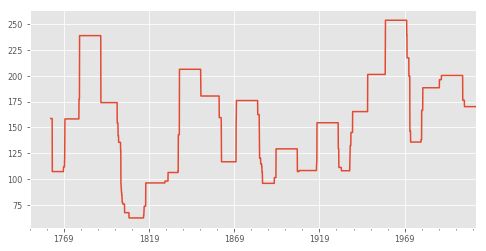

In [5]:
_ = df.y.rolling(window=150).max().plot()

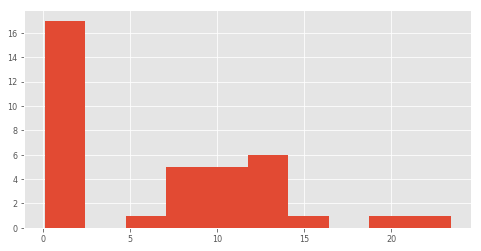

In [6]:
wind_max = df.y.rolling(window=150).max()
pd.Series((wind_max[abs(wind_max.diff())>10].index[1:] - wind_max[abs(wind_max.diff())>10].index[:-1]) / np.timedelta64(1, 'Y')).hist(bins=10)

**2. Smooth the timeseries using a moving average or median**

Recall from the lecture that moving average/median is a form of convolution. One could apply `np.convolve()` to the signal, or use Pandas `rolling()` convenience method.

In [7]:
df['ma'] = df['y'].rolling(window=10, center=True).mean()

**3. Detect outliers by comparing the smoothed timeseries with the raw one**

We take the difference between the original data and the smoothed timeseries, and label all points larger then a given `threshold` value as outliers. What is a good value of `threshold`?

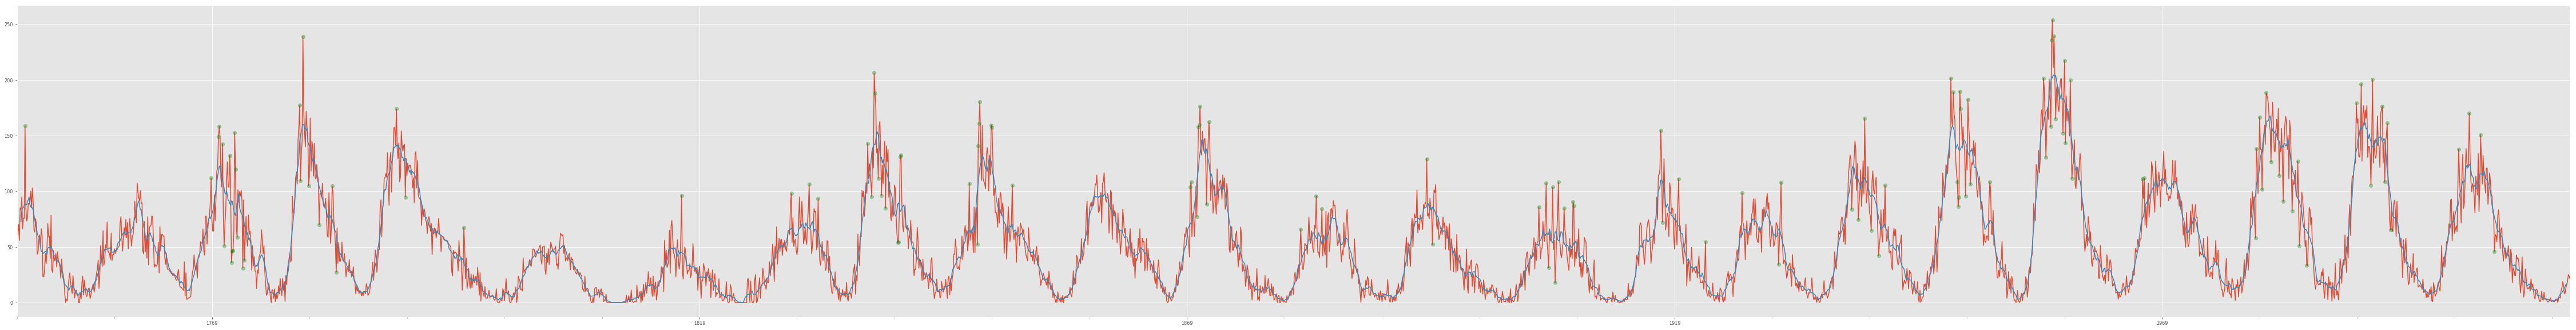

In [8]:
threshold = 30 # arbitrary

difference = np.abs(df['y'] - df['ma'])
outlier_idx = difference > threshold

fig, ax = plt.subplots(figsize=(80, 10))
df['y'].plot()
df['y'][outlier_idx].plot(marker='o', linestyle='none', color='g', alpha=0.3);
df['ma'].plot()

**4a. Can you think of a way of using FFT to smooth the timeseries and label outliers? What could be a limitation of this approach to outlier detection? **

You don't need to actually implement the method, rather come up with some discussion points
to share with the class.

**Answer**: we look at the frequency response of the signal and observe if there is any high frequency component beyond some threshold. If there is, we return the outlier position. FFT removes the time information of the signal completely when we take FFT of the signal. Therefore, if the outlier or noise has similar frequency responses but can be discriminated from their behavior across time the FFT approach would not work.

**4b.  what is one limitation of the approaches we considered so far?**
    
**Answer**: we did not take into account any periodicity in the data.

### Intermezzo: timeseries decomposition

We can follow a similar approach to the one we saw in the timeseries module, and decompose the sunspot data into a seasonal, trend and error (or residual) components.

The general equation is the following:

$x(t)=s(t)+m(t)+e(t)$

where:
 * $t$ is time
 * $x$ is the data
 * $s$ is the seasonal component
 * $e$ is the error term
 * $m$ is the trend

**6. Use FFT to determine the periodicity of the timeseries**

From question 1b, we know that sunspots activity is cyclical, reaching a maximum roughly every $x$ years. Use Fourier analysis to confirm that. Use the `resample` method from pandas to resample the original dataset to yearly measurements. Peform the same fourier analysis on the monthly data. Do the results match?

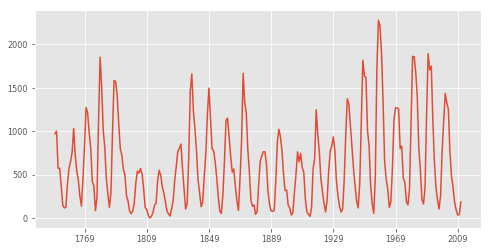

In [9]:
year_df = df['y'].resample('A').sum()
_ = plot(year_df)

If there is a linear trend, this will result in additional frequencies in the Fourier spectrum that are not really there (think about all the harmonics needed in order to describe a sawtooth waveform). We can easiliy solve this by detrending (removing a linear fit) from the signal using the `signal.detrend` function from `scipy`.

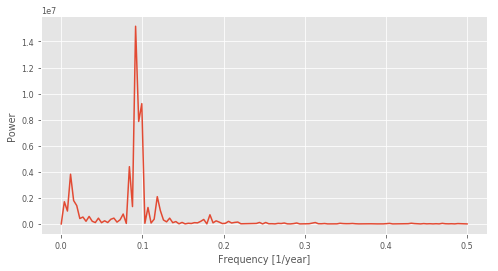

In [10]:
# Perform Fourier transform on the detrended signal.
fourier = fft.rfft(signal.detrend(year_df, type='linear'))

# Calculate the frequencies in the spectrum.
f = rfftfreq(year_df.shape[0], d=1)

# Compute the power spectrum.
power_spectrum = np.absolute(fourier)**2 / len(fourier)

# Make a line plot for the power spectrum.
idx = np.argsort(f)
plt.plot(f[idx], power_spectrum[idx])
xlabel('Frequency [1/year]')
ylabel('Power')

In [11]:
# Find the max frequency.
max_power = np.argmax(power_spectrum)
freq = f[max_power]
print(freq)

0.0916030534351


Note the peak at a frequency of 0.09 frequency units (expressed as 1/year). The period expressed in years is the reciprocal of 1/freq:

In [12]:
print("{:2.1f} years".format(1/freq))

10.9 years


If we look back at our monthly data

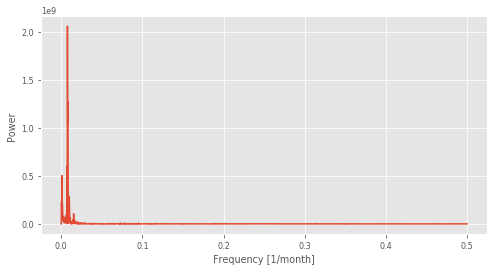

In [13]:
fourier = fft.rfft(signal.detrend(df['y'], type='linear'))
f = rfftfreq(df.shape[0], d=1)
power_spectrum = np.absolute(fourier)**2
idx = np.argsort(f)

plt.plot(f[idx], power_spectrum[idx])
xlabel('Frequency [1/month]')
ylabel('Power')

We take the dominant frequency from the spectogram.

In [14]:
max_power = np.argmax(power_spectrum)
freq = f[max_power]
period = 1/freq
print("{:.2f} years".format(period/12))

10.91 years


In [15]:
period = int(np.round(period)) # months

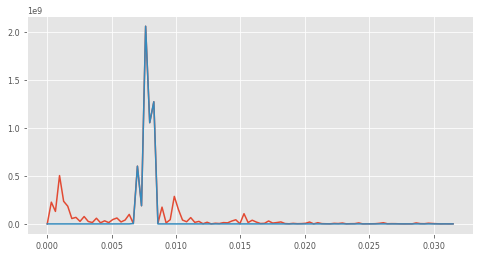

In [16]:
def bandpass_filter(freqs, inp, center_freq, width):
    x = zeros(inp.shape)
    x[abs(abs(freqs) - center_freq) < width] = 1
    return x*inp

spec = fft.fft(signal.detrend(df['y'], type='linear'))

# Apply simple band-pass filtering
spec_filtered = zeros(spec.shape, dtype=complex)
freqs = fft.fftfreq(df.shape[0], d=1)
spec_filtered = bandpass_filter(freqs, spec, 0.0075, 0.001)

# Zoom in onto peak region and show the effect of filtering.
plot(freqs[:100], abs(spec[:100])**2)
plot(freqs[:100], abs(spec_filtered[:100])**2)

We can now invert the filtered fourier spectrum. Note that have to undo detrending in order to recover the original signal.

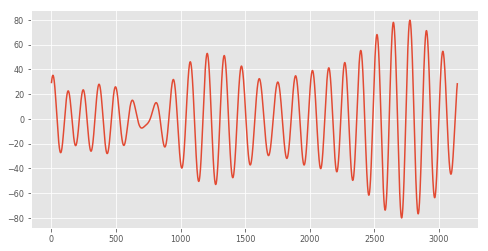

In [17]:
# Plot the inverse response.
plot(fft.ifft(spec_filtered).real)
seasonality = fft.ifft(spec_filtered).real

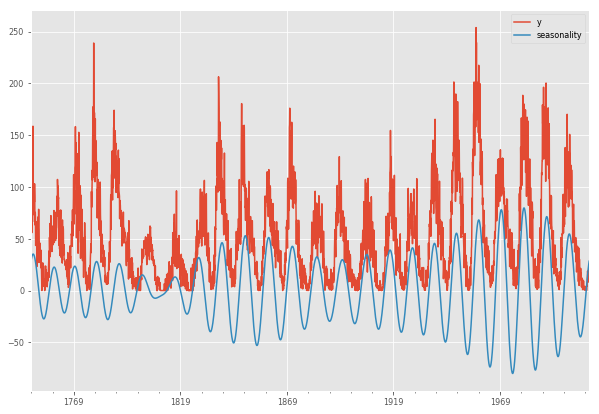

In [18]:
df_plot = df
df_plot['seasonality'] = seasonality
df_plot[['y', 'seasonality']].plot(figsize=(10,7))

Note: Here we only looked at the dominant frequency to determine the period. In reality, there might be more than one frequency we have to account for in determining the seasonality. You can see this by inspecting a plot of `seasonality`. We should also offset the start of our seasonality array to the first occurrence of a cycle.

**6. Find a trend in the timeseries.**

We can use a rolling mean/average with a window equal to the dominant frequency to estimate the timeseries trend.

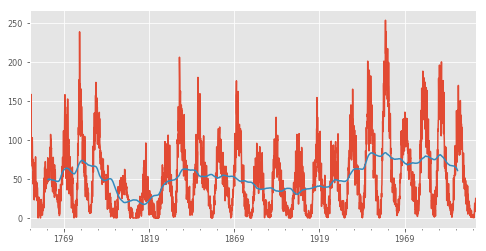

In [19]:
trend = df['y'].rolling(window=2*period, center=True).mean()
df['y'].plot()
trend.plot()

If we now overlay our filtered signal on that, we see that we are approximating the original signal. 

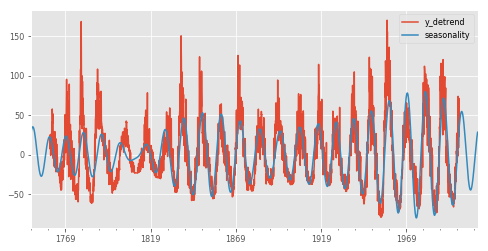

In [20]:
df['y_detrend'] = df['y'] - trend
df[['y_detrend', 'seasonality']].plot()

**7 Exploit the previous steps to calculate the error term by combining the seasonality and trend of the timeseries**

Recall that the error term, for an additive model, is defined as $Error = Data - (Trend + Seasonality)$

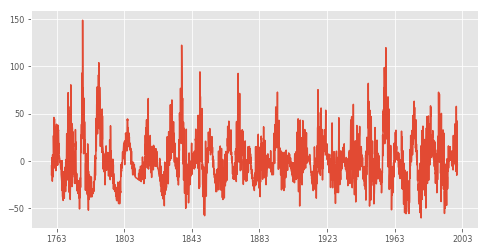

In [21]:
error = df['y'] - (trend + seasonality)
plot(error)

**8. Detect outliers in the error component, and use their index to label the original data.**

One way to label outliers is to perform a simple [IQR test](http://www.purplemath.com/modules/boxwhisk3.htm) to set the threshold.

In [22]:
q95, q5  = error.quantile([.95, .5])
iqr = q95 - q5

We mark the points that fall out of the $(-1.5 IQR, 1.5IQR)$ range as outliers.

In [23]:
outlier_idx = (error > 1.5*iqr) | (error < -1.5*iqr)

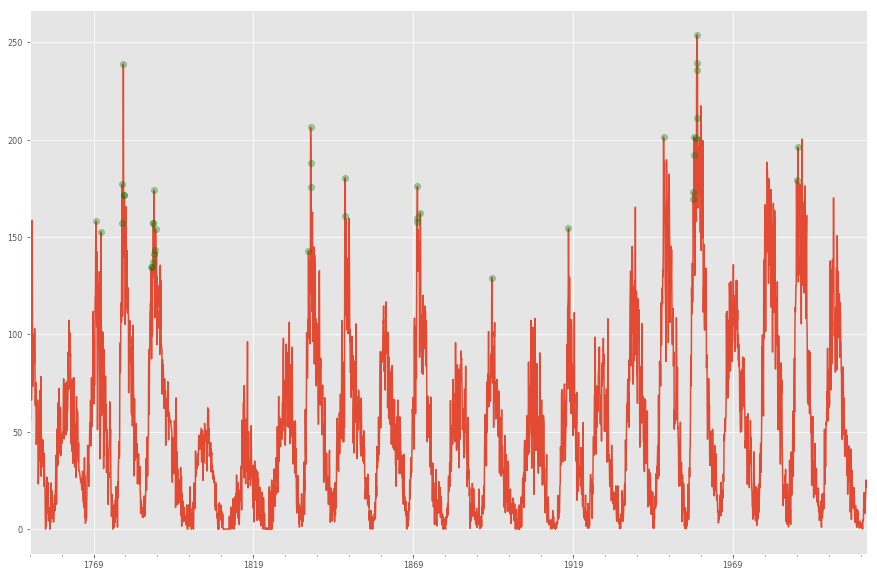

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
df['y'].plot()
df['y'][outlier_idx].plot(marker='o', linestyle='none', color='g', alpha=0.3)

## Extrapolation (bonus execise)

We can formulate the process of data extrapolation as reconstructing a signal. A naive approach can be implemented
following these steps:
 1. look for a linear trend in the signal (see numpy's `polyfit` function or `signal.detrend` in `scipy`)
 2. detrend the signal
 3. calculate the FFT of the detrended signal
 4. select only frequencies higher than a threshold $h$, that you will use to restore the signal
 5. restore and extrapolate the signal as $ \sum_i amplitude_i \cdot \cos(2 \cdot \pi \cdot freq_i + phase_i) $
 6. alternatively, restore and extrapolate the signal using the inverse Fourier transform. Is the result you obtained different than 5? If so, why do you think it is the case?

Implement a `fourier_extrapolation` function following 1-6 and use it to extrapolate monthly sunspot activity. Discuss the results.

**Answer**: one possible solution is given by the following `fourier_extrapolation` function

In [25]:
def fourier_extrapolation(x, n_predict, freq_th=1, n_harm=100):
    n = x.size
    t = np.arange(0, n)
    trend = np.polyfit(t, x, 1) 
    # trend[0] is the residual of the least square fit
    x_notrend = x - trend[0] * t
    fourier = fft.fft(x_notrend)
    f = fft.fftfreq(n, d=t[1]-t[0]) 
    
    # keep only the `h` highest frequencies
    h = np.sort(np.real(fourier))[-freq_th]
    
    fourier = [fourier[i] if np.absolute(fourier[i]) >= h else 0 
               for i in range(len(fourier)) ]
    
    # smooth the reconstructed signal
    # using `n_harm` components of the `h` dominant frequencies
    indexes = np.argsort(f[np.where(f > 0)])
    t = np.arange(0, n + n_predict) 

    restored_sig = np.zeros(t.size)
    for i in indexes[:n_harm]:
        ampli = np.absolute(fourier[i]) / n 
        phase = np.angle(fourier[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + trend[0] * t

In [26]:
last_years = df.y.values

In [27]:
x = np.linspace(1, last_years.size, num=last_years.size)

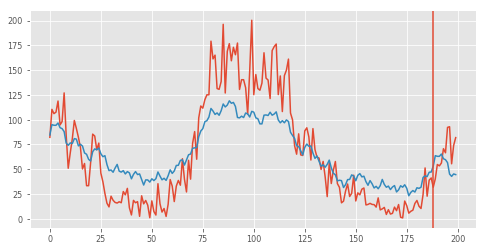

In [28]:
plot(last_years[2800:3000])
plot(fourier_extrapolation(last_years[2800:2988], 12, freq_th=10))
plt.axvline(x=188)

In [29]:
def inverse_fourier_extrapolation(x, n_predict, freq_th=1):
    n = x.size
    t = np.arange(0, n)
    trend = np.polyfit(t, x, 1) 
    x_notrend = x - trend[0] * t
    fourier = fft.fft(x_notrend)
    
    # keep only the `h` highest frequencies
    h = np.sort(real(fourier))[-freq_th]
    
    fourier = [freq if np.absolute(freq) >= h else 0 
               for freq in fourier]
    
    t = np.arange(0, n + n_predict)
    restored_signal = real(np.fft.ifft(fourier, n=n + n_predict))
    return restored_signal + trend[0] * t

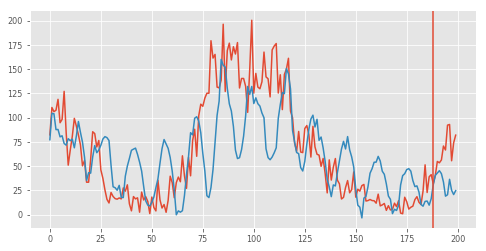

In [30]:
plot(last_years[2800:3000])
plot(inverse_fourier_extrapolation(last_years[2800:2988], 12, freq_th=12))
plt.axvline(x=188);